In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import urllib.request
import tarfile

from pathlib import Path

In [2]:
dataUrl = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"

dataTgzPath = Path("housing.tgz")
dataCsvPath = Path("housing.csv")

if not dataCsvPath.exists():
    urllib.request.urlretrieve(dataUrl, dataTgzPath)
    dataTgzFile = tarfile.open(dataTgzPath)
    dataTgzFile.extractall()
    dataTgzFile.close()
    dataTgzPath.unlink()

housingData = pd.read_csv(dataCsvPath)

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [4]:
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error

HousingDataTrainSet, housingDataTestSet = train_test_split(housingData, test_size=0.2, random_state=42)

HousingDataTrainSetToFit = HousingDataTrainSet.drop("median_house_value", axis=1)
HousingDataTrainSetLabels = HousingDataTrainSet["median_house_value"].copy()

housingDataNumericalOnly = HousingDataTrainSetToFit.drop("ocean_proximity", axis=1)

numericalAttributes = list(housingDataNumericalOnly)
categoricalAttributes = ["ocean_proximity"]

numericalPipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attributes_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

fullPipeline = ColumnTransformer([
    ('numerical', numericalPipeline, numericalAttributes),
    ('categorical', OneHotEncoder(), categoricalAttributes)
])

preparedHousingData = fullPipeline.fit_transform(HousingDataTrainSetToFit)

In [5]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression()
linReg.fit(preparedHousingData, HousingDataTrainSetLabels)

housingPredictions = linReg.predict(preparedHousingData)
mse = mean_squared_error(HousingDataTrainSetLabels, housingPredictions)
rmse = np.sqrt(mse)
print(f"Typical prediction error: ${rmse}")

Typical prediction error: $67593.20745775253


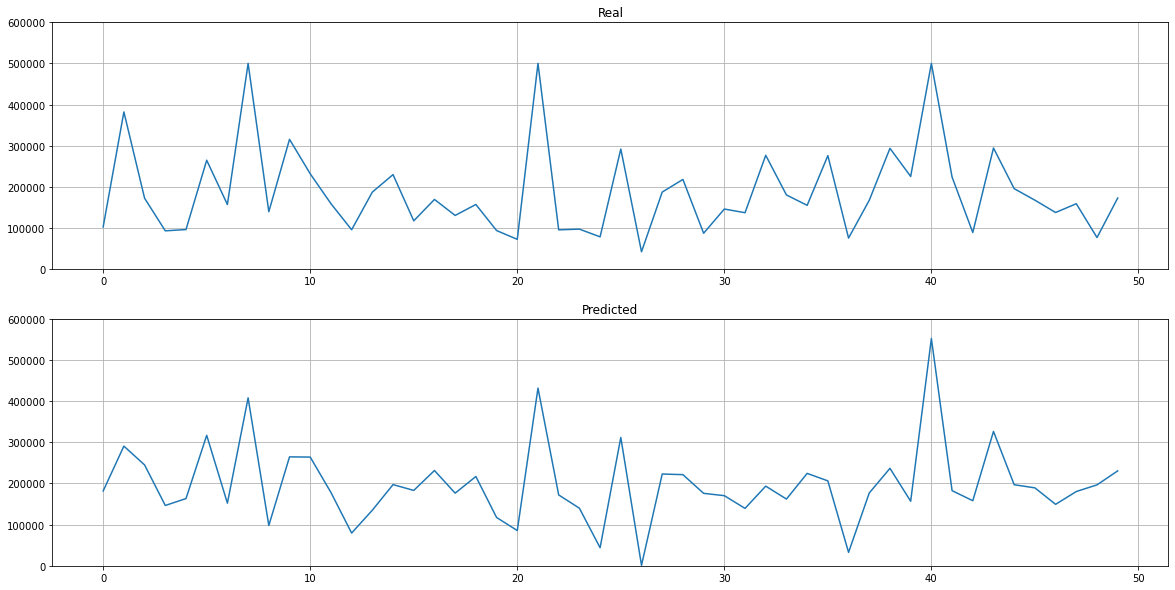

In [6]:
# Trying the full preprocessing pipeline on a few training instances
someData = HousingDataTrainSetToFit.iloc[:50]
someLabels = HousingDataTrainSetLabels.iloc[:50]
someDataPrepared = fullPipeline.transform(someData)

fig, axs = plt.subplots(2, figsize=(20,10))

axs[0].set_title("Real")
axs[0].plot(list(someLabels))

axs[1].set_title("Predicted")
axs[1].plot(linReg.predict(someDataPrepared))

axs[0].set_ylim(bottom=0, top=600000)
axs[1].set_ylim(bottom=0, top=600000)

axs[0].grid()
axs[1].grid()

plt.show()

In [7]:
from sklearn.tree import DecisionTreeRegressor

treeReg = DecisionTreeRegressor()
treeReg.fit(preparedHousingData, HousingDataTrainSetLabels)

housingPredictions = treeReg.predict(preparedHousingData)
mse = mean_squared_error(HousingDataTrainSetLabels, housingPredictions)
rmse = np.sqrt(mse)
print(f"Typical prediction error: ${rmse}")

Typical prediction error: $0.0


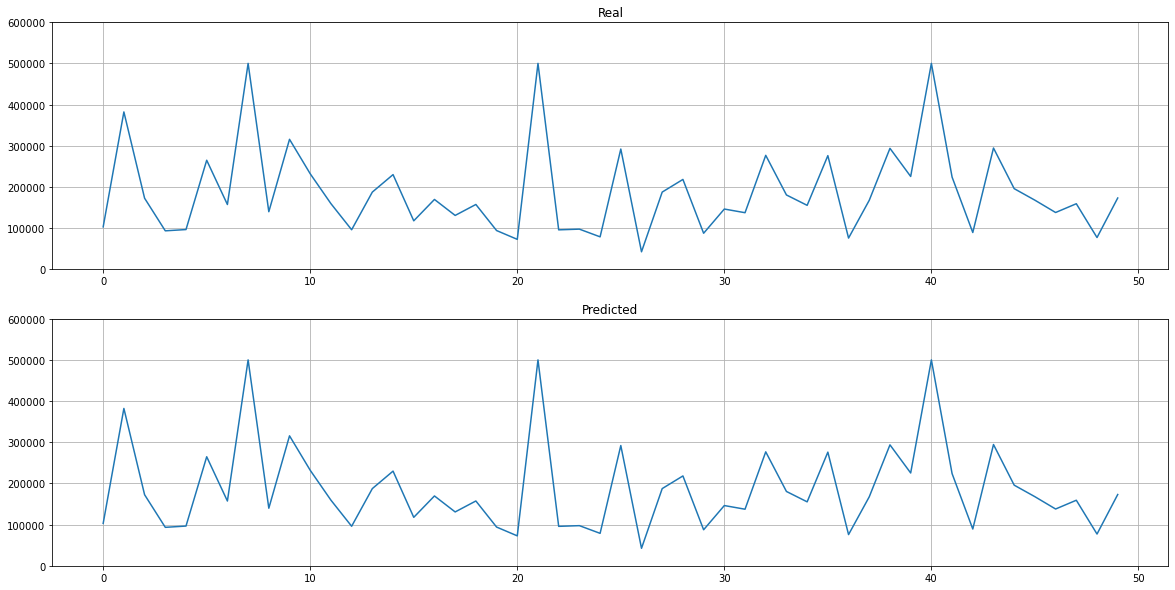

In [8]:
# Trying the full preprocessing pipeline on a few training instances
someData = HousingDataTrainSetToFit.iloc[:50]
someLabels = HousingDataTrainSetLabels.iloc[:50]
someDataPrepared = fullPipeline.transform(someData)

fig, axs = plt.subplots(2, figsize=(20,10))

axs[0].set_title("Real")
axs[0].plot(list(someLabels))

axs[1].set_title("Predicted")
axs[1].plot(treeReg.predict(someDataPrepared))

axs[0].set_ylim(bottom=0, top=600000)
axs[1].set_ylim(bottom=0, top=600000)

axs[0].grid()
axs[1].grid()

plt.show()

In [9]:
from sklearn.ensemble import RandomForestRegressor

forestReg = RandomForestRegressor()
forestReg.fit(preparedHousingData, HousingDataTrainSetLabels)

housingPredictions = forestReg.predict(preparedHousingData)
mse = mean_squared_error(HousingDataTrainSetLabels, housingPredictions)
rmse = np.sqrt(mse)
print(f"Typical prediction error: ${rmse}")

Typical prediction error: $18596.399744732826


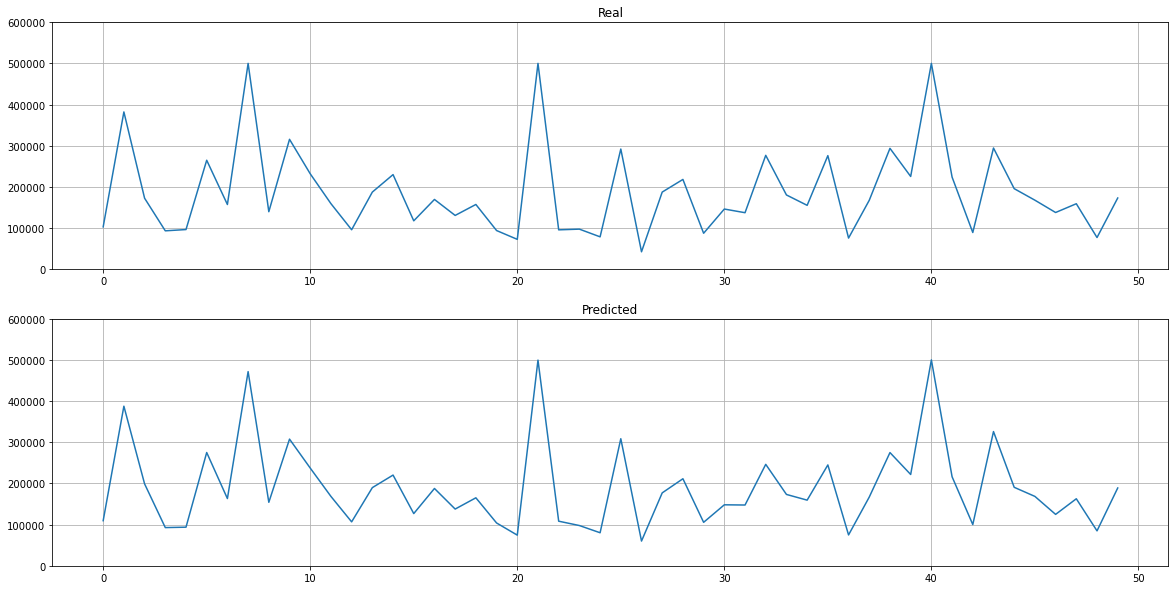

In [10]:
# Trying the full preprocessing pipeline on a few training instances
someData = HousingDataTrainSetToFit.iloc[:50]
someLabels = HousingDataTrainSetLabels.iloc[:50]
someDataPrepared = fullPipeline.transform(someData)

fig, axs = plt.subplots(2, figsize=(20,10))

axs[0].set_title("Real")
axs[0].plot(list(someLabels))

axs[1].set_title("Predicted")
axs[1].plot(forestReg.predict(someDataPrepared))

axs[0].set_ylim(bottom=0, top=600000)
axs[1].set_ylim(bottom=0, top=600000)

axs[0].grid()
axs[1].grid()

plt.show()